In [16]:
import numpy as np
import pandas as pd
import torch
import csv
import math
import gc
import matplotlib.pyplot as plt

from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import logging
from scipy.stats import spearmanr

logging.set_verbosity_error() # turn off annoying model initialisation warning

In [17]:
# Reset variables and recover memory
gc.collect()
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  n


Nothing done.


In [25]:
class similarity_analysis(object):
    
    def __init__(self):
        self.models = list(self.model_embed_storage.keys())
        self.datasets = list(self.dataset_storage.keys())
        self.generate_vocab_set()
        print('Available models:')
        print(self.models)
        print('Available datasets:')
        print(self.datasets)
        return(None)
    
    # Define file location variables
    folder_loc= 'D:/Study and Projects/School Work/Year 25 - PhD 1/Data//'
    model_loc = 'Word Embeddings//'
    sent_loc = 'Sentence Embeddings//'
    dataset_loc = 'Word Similarity Data/Collection of Word Similarity Benchmarks//'

    model_files = {'glove':'Glove Word Embeddings/glove.840B.300d.mini.txt',
                   'CW_vectors':'Collobert and Weston Vectors/embeddings.txt',
                   'dm_vectors':'Distributional Memory Embeddings/dm_vectors_mini.txt',
                   'fasttext_wiki+giga':'FastText Skipgram wiki+giga/model_mini.txt',
                   'conceptnet':'ConceptNet Embeddings/numberbatch-en-mini.txt',
                   'word2vec_skip':'Word2vec Skipgram CoNLL17/model_mini.txt',
                   'lexvec':'LexVec Embeddings/lexvec_wiki+newscrawl_300d_mini.txt',
                   'bert':'bert-base-uncased',
                   'elmo':'Elmo Embeddings/elmo_mini.txt',
                   'gensim_skip':'Gensim Skipgram wiki+giga/model_mini.txt',
                   'electra':'electra-base-discriminator',
                   'wordnet':'WordNet Word Embeddings/wn2vec_mini.txt',
                   'gensim_cbow':'Gensim CBoW giga/2010_mini.txt',
                   'gpt2':'gpt2',
                   'bert_context':'simverb_bert_context.txt'
                  }
        
    dataset_files = {'RG65':'EN-RG-65.txt',
                     'YP130':'EN-YP-130.txt',
                     'MTurk287':'EN-MTurk-287.txt',
                     'MTurk213':'EN-MTurk-213-no-prop.txt',
                     'MTurk771':'EN-MTurk-771.txt',
                     'WS198':'EN-WS-198-SIM-no-prop.txt',
                     'RW':'EN-RW-STANFORD.txt',
                     'MEN':'EN-MEN-TR-3k.txt',
                     'SimVerb':'EN-SimVerb-3500.txt',
                     'SimLex':'EN-SIMLEX-999.txt',
                     'SimLexN':'EN-SIMLEX-999-NOUN.txt',
                     'SimLexV':'EN-SIMLEX-999-VERB.txt',
                     'SimLexA':'EN-SIMLEX-999-ADJ.txt',
                     'SimVerb_na':'SimVerb3360_no_ant.txt',
                     'SimVerb_nax':'SimVerb3340_no_ant_aux.txt'
                    }
    
    # these storage vectors are loading in the embeddings or datasets directly as numpy arrays
    model_embed_storage = {'CW_vectors':[], 'dm_vectors':[],
                           'gensim_cbow':[], 'gensim_skip':[], 'word2vec_skip':[],
                           'glove':[], 'fasttext_wiki+giga':[], 'lexvec':[], 'elmo':[],
                           'conceptnet':[], 'wordnet':[], 
                           'bert':[], 'gpt2':[], 'electra':[], 'bert_context':[]}
     
    dataset_storage = {'RG65':[], 'YP130':[], 'MTurk287':[], 'MTurk213':[], 'WS198':[], 'MTurk771':[], 
                       'RW':[], 'MEN':[], 'SimLex':[], 'SimLexN':[], 'SimLexV':[], 'SimLexA':[], 'SimVerb':[], 'SimVerb_na':[], 'SimVerb_nax':[]}
    
    # these storage vectors are for dictoniaries with pre-computed similarities
    model_sim_storage = {'CW_vectors':{}, 'dm_vectors':{},
                         'gensim_cbow':{}, 'gensim_skip':{}, 'word2vec_skip':{}, 
                         'glove':{}, 'fasttext_wiki+giga':{}, 'lexvec':{}, 'elmo':{}, 
                         'conceptnet':{}, 'wordnet':{}, 
                         'bert':{}, 'gpt2':{}, 'electra':{}, 'bert_context':{}}
    
    dataset_sim_storage = {'RG65':{}, 'YP130':{}, 'MTurk287':{}, 'MTurk213':{}, 'WS198':{}, 'MTurk771':{}, 
                           'RW':{}, 'MEN':{}, 'SimLex':{}, 'SimLexN':{}, 'SimLexV':{}, 'SimLexA':{}, 'SimVerb':{}, 'SimVerb_na':{}, 'SimVerb_nax':{}}
    
    transformers = {'bert','electra','xlm'}
    
    unique_vocab_set = []
    
    rare_word_loc = folder_loc+'Corpus Data/Key vocab/Rare_Words_substitutions.csv'
    RW_mod_pd = pd.read_csv(rare_word_loc, index_col=0, header=None, on_bad_lines='skip')
    RW_mod_dict = RW_mod_pd.to_dict()[1] 
    
    
    # Generate full set of unique vocabulary needed
    def generate_vocab_set(self):
        full_vocab_set = []
        for dataset in self.dataset_storage.keys():
            if len(self.dataset_storage[dataset])==0: # load dataset if needed
                self.import_dataset(dataset)
            wordset = self.dataset_storage[dataset][0] # get set of words in that dataset
            for wordpair in wordset:
                full_vocab_set.append(wordpair[0])
                full_vocab_set.append(wordpair[1])
        unique_vocab_set = list(set(full_vocab_set)) # unique words only
        unique_vocab_set.sort()
        self.unique_vocab_set = unique_vocab_set
        print('Total tested words:',len(full_vocab_set))
        print('Unique tested words:',len(unique_vocab_set))
        
    
    # Simple function to print a single model
    def print_model(self, model_name):
        """ string -> None
        Print a summary of the embeddings for a given model.
        """
        if self.model_embed_storage[model_name]==0:
            print('not loaded')
        else:
            display(self.model_embed_storage[model_name][0])
    
    
    # Function to import all models into the storage dictionary
    def import_all_models(self):
        """ None -> None
        Imports all models into the model_embed_storage dictionary.
        """
        for model in self.model_embed_storage:
            self.import_model(model)
            
            
    # Function to load a specific word embedding model
    def import_model(self, model_name):
        """ string -> None
        Imports an embedding model, storing it in the model_embed_storage dictionary.
        """
        if len(self.model_embed_storage[model_name])==0: #only if its not already loaded
            if model_name in self.transformers: # for transformer models
                file_loc = self.model_files[model_name]
                filename = self.folder_loc+self.sent_loc+file_loc
                config_state = AutoConfig.from_pretrained(filename, output_hidden_states=True) # get hidden states
                tokenizer = AutoTokenizer.from_pretrained(filename)
                model = AutoModel.from_pretrained(filename, config=config_state)
                self.model_embed_storage[model_name] = (model,tokenizer) # need the model and tokeniser
           
            elif model_name == 'gpt2':
                file_loc = self.model_files[model_name]
                filename = self.folder_loc+self.sent_loc+file_loc
                tokenizer = GPT2Tokenizer.from_pretrained(filename)
                model = GPT2LMHeadModel.from_pretrained(filename)
                self.model_embed_storage[model_name] = (model,tokenizer)
                               
           # elif model_name=='gensim_skip':
           #     file_loc = self.model_files[model_name]
           #     filename = self.folder_loc+self.model_loc+file_loc
           #     self.model_embed_storage[model_name] = [pd.read_csv(filename, index_col=0, header=None, sep=',', on_bad_lines='skip', encoding='latin-1')]
                                                  
            else: # for static word embedding models
                file_loc = self.model_files[model_name]
                filename = self.folder_loc+self.model_loc+file_loc
                with open(filename) as file:
                    lines = [line.rstrip('\n') for line in file]

                model_dict = {} # word dictionary for specific model
                for line in lines:
                    word_list = line.split()
                    word = word_list[0]
                    if word in self.unique_vocab_set: # only need the words we will use for testing
                        embedding_list = [float(x) for x in word_list[1:-1]]
                        embedding_np = np.array(embedding_list)
                        model_dict[word] = embedding_np
                    else:
                        continue
                
                self.model_embed_storage[model_name] = model_dict # store model dictionary in the dictionary for all the models
        
            print(model_name+' loaded')
            
    
    # Function to load word similarity data for specified dataset
    def import_dataset(self, dataset_name):
        """ string -> None
        Imports a dataset, storing a value of the form (list, numpy_array) in the dataset_storage dictionary.
        """
        if len(self.dataset_storage[dataset_name])==0: # if dataset not yet loaded
            file_loc = self.dataset_files[dataset_name]
            filename = self.folder_loc+self.dataset_loc+file_loc
            with open(filename) as file:
                lines = file.readlines()

            wordpairs = [None]*len(lines) # initialise storage
            ratings = [None]*len(lines)
            i=0
            for line in lines:
                line = line.strip() # remove new line chars
                wordpairs[i] = line.split() # split at any whitespace chars
                ratings[i] = float(wordpairs[i][2])
                i=i+1
            ratings = np.array(ratings)

            self.dataset_storage[dataset_name] = (wordpairs, ratings)
            #print(dataset_name+' loaded')
        
    
    # Function to get the embedding for a specific word, given a model
    def get_word_embed(self, model_name, word, layer, comp_method):
        """ string, string, integer, string -> numpy_array, boolean
        Gets the word embedding for a specied model and word. Also takes a 'layer' argument which
        specifies which layer of the hidden layer is extracted from transformer models.
        The 'comp_method' argument specifies the method for extracting the word emedding.
        """
        self.import_model(model_name)
        model = self.model_embed_storage[model_name]
        RW_set = self.RW_mod_pd.index.values
        missed = False
        
        if model_name == 'gpt2': # gpt2 case as its structure is different to BERT
            model_main = model[0]
            tokenizer = model[1] # transformers need a tokenizer as well
            encoded_input = tokenizer.encode(word, add_prefix_space=True, return_tensors='pt')
            word_embedding_raw = model_main.transformer.wte.weight[encoded_input,:].detach().numpy()[0][0]
            word_embedding = word_embedding_raw.reshape(-1)
        
        elif model_name in self.transformers: # for BERT-like transformer models
            model_main = model[0]
            tokenizer = model[1]
            encoded_input = tokenizer(word, return_tensors='pt') #pt = pytorch
            model_output = model_main(**encoded_input)
            word_embedding_raw = model_output.hidden_states[layer].detach().numpy()[0]
                
            # embeddings depend on the comp_method chosen
            if comp_method=='mean': # take the mean of all tokens
                word_embedding = word_embedding_raw.mean(axis=0)
            elif comp_method=='cls': # use the 'CLS' token
                word_embedding = word_embedding_raw[0]
            elif comp_method=='decontext': # take the mean of word tokens only
                word_embedding = word_embedding_raw[1:-1].mean(axis=0)
                
        else: # for static word embedding models
            embed_dim = model['man'].shape[0] # get embedding length
            try:
                alt_word = self.RW_mod_dict[word] # alterantive word for RW dataset (similar meaning)
            except:
                alt_word = 0 # no alt word available
            
            word_list = model.keys() # list of all words in the current model
            if word in word_list:
                word_embed = model[word] # get embedding from pandas array
            elif alt_word!=0 and alt_word in word_list: # try alt word if one is defined
                #print('substituting '+alt_word)
                word_embed = model[alt_word]
            elif word.capitalize() in word_list: # see if capitalised is in there
                word_embed = model[word.capitalize()]
            elif word.lower() in word_list: # see if lower case is in there
                word_embed = model[word.lower()]
            elif word[0:-1] in word_list: # see if non-plural is there
                word_embed = model[word[0:-1]]
            elif word[-2:]=='ed' and word[0:-2] in word_list: # see if non-past tense is there
                word_embed = model[word[0:-2]]
            elif word[-3:]=='ing' and word[0:-3] in word_list: # see if non-infinitive form is there
                word_embed = model[word[0:-3]]
            else: # if the word can't be found in the model
                #print('missing '+word)
                word_embed = np.random.rand(1,100)[0] # random embedding
                missed = True
                
            word_embedding = np.array(word_embed)
 
        return(word_embedding, missed)
    
    
    # Function to compute the similarities of all word pairs from a given database, for a given model
    def compute_model_sims(self, model_name, dataset_name, layer, comp_method):
        """ string, string, integer, string -> float_list
        Returns a list of similarities for all word pairs in a specified dataset, using a specified model.
        """
        self.import_dataset(dataset_name) # load dataset if needed
        dataset_words = self.dataset_storage[dataset_name][0] # word pairs in [0]
        embed_sims = [None]*len(dataset_words)
        i=0
        for word_pair in dataset_words:
            word_embed_1,miss_1 = self.get_word_embed(model_name, word_pair[0], layer, comp_method)
            word_embed_2,miss_2 = self.get_word_embed(model_name, word_pair[1], layer, comp_method)
            if miss_1==True or miss_2==True:
                embed_sims[i] = math.nan # return NaN if either word is missing
            else:
                embed_sims[i] = self.cosine_sim(word_embed_1, word_embed_2)
            i=i+1
        return(embed_sims)
    
    
    # Function to calculate cosine similarity between two embeddings
    def cosine_sim(self, embed_1, embed_2):
        """ numpy_array, numpy_array -> float
        Returns the cosine similarity (-1 to 1) between two embeddings, inputted as vectors.
        """
        if np.dot(embed_1,embed_2) == 0:
            similarity = 0 # don't normalise if similarity is zero
        else:
            similarity = np.dot(embed_1,embed_2)/(np.linalg.norm(embed_1)*np.linalg.norm(embed_2))
        return(similarity)
       
    
    # Function to compute the correlation between model and dataset embedding similarities
    def compute_embed_correls(self, model_name, dataset_name, layer, comp_method):
        """ string, string, int, string -> (float, float)
        Computes the pearson_r and spearman_r between word similarities for a dataset and model.
        """
        self.import_dataset(dataset_name) # load model and dataset if needed
        self.import_model(model_name)
        model_sims = self.compute_model_sims(model_name, dataset_name, layer, comp_method)
        dataset_sims = self.dataset_storage[dataset_name][1] # similarities stored in [1]
        
        model_masked = np.ma.masked_invalid(model_sims) # get mask to avoid NaN values
        dataset_masked = np.ma.masked_invalid(dataset_sims)
        full_mask = (~model_masked.mask & ~dataset_masked.mask) # combine masks for model and dataset similarities
        pearson_r = np.corrcoef(model_masked[full_mask], dataset_masked[full_mask])[0,1] # correlation with masks
        spearman_r, p = spearmanr(model_masked[full_mask], dataset_masked[full_mask])
        print('missing words: '+str(len(full_mask)-sum(full_mask))+' out of '+str(len(full_mask)))
        
        return(pearson_r, spearman_r)
    
    
    # Function to calculate the correlation between model and experimental similarities
    def model_vs_data(self, model_name, dataset_name, layer=0, comp_method='mean'):
        """ string, string, int, string -> None
        Prints the correlation between the experimental and calculated similarities for a given
        model and dataset. Requires layer and comp_method to be specified.
        """
        correlations = self.compute_embed_correls(model_name, dataset_name, layer, comp_method)
        print('evaluating '+model_name+' against '+dataset_name)
        print('pearson: {:.3f}'.format(correlations[0]), '\nspearman: {:.3f}\n'.format(correlations[1]))
        
        
    # Store similarities in dictionaries for future use
    def store_similarities(self, model_name, dataset_name):
        dataset_vocab = self.dataset_storage[dataset_name][0] # get dataset vocab
        model_sims = self.compute_model_sims(model_name, dataset_name, layer=12, comp_method='decontext')
        i=0
        for word_pair in dataset_vocab:
            word_pair_str = word_pair[0]+' '+word_pair[1] # word pair as string for dictionary storage
            self.dataset_sim_storage[dataset_name][word_pair_str] = dataset_vocab[i][2] # store experimental similarity from dataset
            self.model_sim_storage[model_name][word_pair_str] = model_sims[i] # store model-based similarity            
            i=i+1
        #print('Similarities for '+model_name+' with '+dataset_name+' saved')
        
        
    # Bootstrap a set of draws for a given dataset and model
    def single_bootstrap(self, model_name, dataset, layer=12, comp_method='decontext'):
        self.store_similarities(model_name, dataset)

        # Generate bootstrap sample
        n = len(self.dataset_sim_storage[dataset].keys()) # size of vocab set
        index_list = np.arange(0,n)
        vocab_pair_list = list(self.dataset_sim_storage[dataset].keys())
        rd_indices = np.random.choice(index_list,n) # get random indices for choosing vocab
        rd_vocab_model_sims = np.zeros(n)
        rd_vocab_exper_sims = np.zeros(n)
        i=0
        for index in rd_indices:
            rd_vocab = vocab_pair_list[index] # get random vocab pair
            rd_vocab_model_sims[i] = self.model_sim_storage[model_name][rd_vocab] # get model similarity
            rd_vocab_exper_sims[i] = self.dataset_sim_storage[dataset][rd_vocab] # get experimental similarity
            i=i+1

        # Compute correlations
        rd_vocab_model_sims_msk = np.ma.masked_invalid(rd_vocab_model_sims) # get mask to avoid NaN values
        rd_vocab_exper_sims_msk = np.ma.masked_invalid(rd_vocab_exper_sims)
        full_mask = (~rd_vocab_model_sims_msk.mask & ~rd_vocab_exper_sims_msk.mask) # combine masks for model and dataset similarities       
        pearson_r = np.corrcoef(rd_vocab_model_sims[full_mask], rd_vocab_exper_sims[full_mask])[0,1]
        spearman_r, p = spearmanr(rd_vocab_model_sims[full_mask], rd_vocab_exper_sims[full_mask])
        return(pearson_r, spearman_r)
    
    
    # Compute a series of bootstrap samples for a given model and dataset
    def set_of_bootstraps(self, model_name, dataset, num_samples=100, layer=12, comp_method='decontext'):
        corr_samples_pearson = []
        corr_samples_spearman = []
        for run in np.arange(0,num_samples):
            correlations = sim.single_bootstrap(model_name, dataset, layer, comp_method)
            corr_samples_pearson.append(correlations[0])
            corr_samples_spearman.append(correlations[1])
            
        return(corr_samples_pearson, corr_samples_spearman)
    
    
    def plot_model_bootstraps(self, dataset_name, num_samples=100):
        mean_correlations = np.array([])
        CI_95_percents = np.array([])
        
        # compute mean and std dev of correlations between all models and specified dataset
        for model in sim.models[0:-3]:
            pearson_corrs, spearman_corrs = sim.set_of_bootstraps(model, dataset_name, num_samples)
            mean_correlations = np.append(mean_correlations, np.mean(spearman_corrs))
            pt_5, pt_95 = np.percentile(spearman_corrs, [5,95]) # get percentiles for 95% CI
            CI_95_percents = np.append(CI_95_percents, (pt_95-pt_5)/2)
            print('finished '+model)
        
        # plot barplot
        fig, ax = plt.subplots(figsize=(14,4))
        ax.bar(x=sim.models[0:-3], #x-coordinates of bars
               height=mean_correlations, #height of bars
               yerr=CI_95_percents, #error bar width
               capsize=6) #length of error bar caps
        plt.show()
        
        return(mean_correlations, CI_95_percents)

In [26]:
sim = similarity_analysis()

Total tested words: 37808
Unique tested words: 5701
Available models:
['CW_vectors', 'dm_vectors', 'gensim_cbow', 'gensim_skip', 'word2vec_skip', 'glove', 'fasttext_wiki+giga', 'lexvec', 'elmo', 'conceptnet', 'wordnet', 'bert', 'gpt2', 'electra', 'bert_context']
Available datasets:
['RG65', 'YP130', 'MTurk287', 'MTurk213', 'WS198', 'MTurk771', 'RW', 'MEN', 'SimLex', 'SimLexN', 'SimLexV', 'SimLexA', 'SimVerb', 'SimVerb_na', 'SimVerb_nax']


In [27]:
sim.import_all_models()

CW_vectors loaded
dm_vectors loaded
gensim_cbow loaded
gensim_skip loaded
word2vec_skip loaded
glove loaded
fasttext_wiki+giga loaded
lexvec loaded
elmo loaded
conceptnet loaded
wordnet loaded
bert loaded
gpt2 loaded
electra loaded
bert_context loaded


In [15]:
sim.model_vs_data('bert_context','SimVerb_na', layer=0, comp_method='decontext')

missing words: 4 out of 3367
evaluating bert_context against SimVerb_na
pearson: 0.447 
spearman: 0.442



finished CW_vectors
finished dm_vectors
finished gensim_cbow
finished gensim_skip
finished word2vec_skip
finished glove
finished fasttext_wiki+giga
finished lexvec
finished elmo
finished conceptnet
finished wordnet


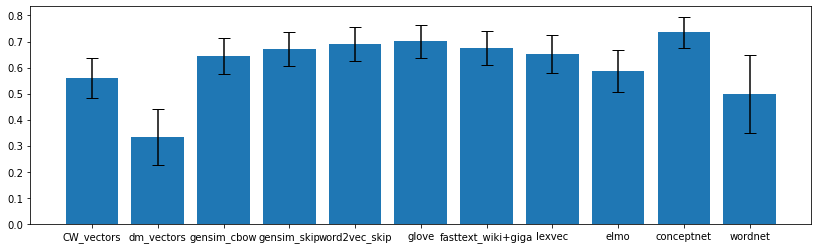

In [299]:
means, errors = sim.plot_model_bootstraps('MTurk213', 1000)

finished CW_vectors
finished dm_vectors
finished gensim_cbow
finished gensim_skip
finished word2vec_skip
finished glove
finished fasttext_wiki+giga
finished lexvec
finished elmo
finished conceptnet
finished wordnet


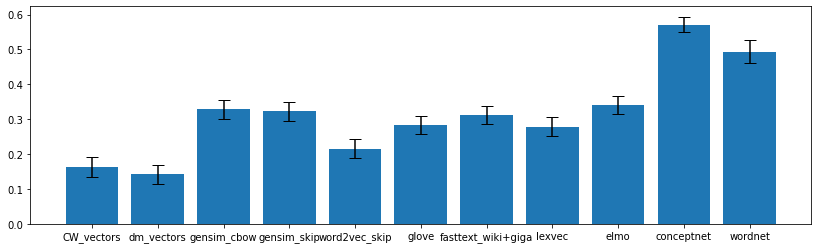

In [302]:
means, errors = sim.plot_model_bootstraps('SimVerb', 1000)

finished CW_vectors
finished dm_vectors
finished gensim_cbow
finished gensim_skip
finished word2vec_skip
finished glove
finished fasttext_wiki+giga
finished lexvec
finished elmo
finished conceptnet
finished wordnet


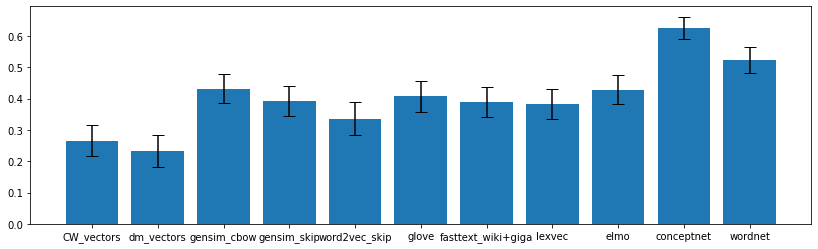

In [303]:
means, errors = sim.plot_model_bootstraps('SimLex', 1000)

In [191]:
for model in sim.models:
    sim.model_vs_data(model,'RG65', layer=0, comp_method='decontext')

CW_vectors loaded
missing words: 0 out of 65
evaluating CW_vectors against RG65
pearson: 0.469 
spearman: 0.467

dm_vectors loaded
missing words: 0 out of 65
evaluating dm_vectors against RG65
pearson: 0.539 
spearman: 0.422

gensim_cbow loaded
missing words: 0 out of 65
evaluating gensim_cbow against RG65
pearson: 0.695 
spearman: 0.680

gensim_skip loaded
missing words: 0 out of 65
evaluating gensim_skip against RG65
pearson: 0.735 
spearman: 0.714

word2vec_skip loaded
missing words: 0 out of 65
evaluating word2vec_skip against RG65
pearson: 0.696 
spearman: 0.698

missing words: 0 out of 65
evaluating glove against RG65
pearson: 0.771 
spearman: 0.771

fasttext_wiki+giga loaded
missing words: 0 out of 65
evaluating fasttext_wiki+giga against RG65
pearson: 0.741 
spearman: 0.711

lexvec loaded
missing words: 0 out of 65
evaluating lexvec against RG65
pearson: 0.760 
spearman: 0.747

elmo loaded
missing words: 0 out of 65
evaluating elmo against RG65
pearson: 0.721 
spearman: 0.717



In [92]:
for model in sim.models:
    sim.model_vs_data(model,'MTurk287', layer=0, comp_method='decontext')

MTurk287 loaded
missing words: 1 out of 287
evaluating CW_vectors against MTurk287
pearson: 0.614 
spearman: 0.587

missing words: 23 out of 287
evaluating gensim_cbow against MTurk287
pearson: 0.651 
spearman: 0.612

missing words: 21 out of 287
evaluating gensim_skip against MTurk287
pearson: 0.699 
spearman: 0.645

missing words: 0 out of 287
evaluating word2vec_skip against MTurk287
pearson: 0.726 
spearman: 0.701

missing words: 0 out of 287
evaluating glove against MTurk287
pearson: 0.737 
spearman: 0.688

missing words: 21 out of 287
evaluating fasttext_wiki+giga against MTurk287
pearson: 0.709 
spearman: 0.655

missing words: 0 out of 287
evaluating lexvec against MTurk287
pearson: 0.697 
spearman: 0.656

missing words: 0 out of 287
evaluating elmo against MTurk287
pearson: 0.600 
spearman: 0.585

missing words: 0 out of 287
evaluating conceptnet against MTurk287
pearson: 0.767 
spearman: 0.721

missing words: 169 out of 287
evaluating wordnet against MTurk287
pearson: 0.491 
s

In [93]:
for model in sim.models:
    sim.model_vs_data(model,'MTurk213', layer=0, comp_method='decontext')

MTurk213 loaded
missing words: 1 out of 213
evaluating CW_vectors against MTurk213
pearson: 0.595 
spearman: 0.559

missing words: 6 out of 213
evaluating gensim_cbow against MTurk213
pearson: 0.664 
spearman: 0.637

missing words: 2 out of 213
evaluating gensim_skip against MTurk213
pearson: 0.709 
spearman: 0.676

missing words: 0 out of 213
evaluating word2vec_skip against MTurk213
pearson: 0.736 
spearman: 0.692

missing words: 0 out of 213
evaluating glove against MTurk213
pearson: 0.756 
spearman: 0.704

missing words: 2 out of 213
evaluating fasttext_wiki+giga against MTurk213
pearson: 0.719 
spearman: 0.677

missing words: 0 out of 213
evaluating lexvec against MTurk213
pearson: 0.698 
spearman: 0.648

missing words: 0 out of 213
evaluating elmo against MTurk213
pearson: 0.615 
spearman: 0.591

missing words: 0 out of 213
evaluating conceptnet against MTurk213
pearson: 0.792 
spearman: 0.739

missing words: 109 out of 213
evaluating wordnet against MTurk213
pearson: 0.489 
spea

In [159]:
for model in sim.models:
    sim.model_vs_data(model,'WS353', layer=0, comp_method='decontext')

WS353 loaded
missing words: 0 out of 353
evaluating CW_vectors against WS353
pearson: 0.507 
spearman: 0.498

missing words: 14 out of 353
evaluating dm_vectors against WS353
pearson: 0.361 
spearman: 0.299

missing words: 0 out of 353
evaluating gensim_cbow against WS353
pearson: 0.622 
spearman: 0.644

missing words: 0 out of 353
evaluating gensim_skip against WS353
pearson: 0.639 
spearman: 0.672

missing words: 0 out of 353
evaluating word2vec_skip against WS353
pearson: 0.700 
spearman: 0.711

missing words: 0 out of 353
evaluating glove against WS353
pearson: 0.719 
spearman: 0.722

missing words: 0 out of 353
evaluating fasttext_wiki+giga against WS353
pearson: 0.660 
spearman: 0.688

missing words: 0 out of 353
evaluating lexvec against WS353
pearson: 0.635 
spearman: 0.661

missing words: 0 out of 353
evaluating elmo against WS353
pearson: 0.538 
spearman: 0.542

missing words: 0 out of 353
evaluating conceptnet against WS353
pearson: 0.753 
spearman: 0.815

missing words: 15 

In [94]:
for model in sim.models:
    sim.model_vs_data(model,'WS198', layer=0, comp_method='decontext')

WS198 loaded
missing words: 0 out of 198
evaluating CW_vectors against WS198
pearson: 0.606 
spearman: 0.585

missing words: 0 out of 198
evaluating gensim_cbow against WS198
pearson: 0.747 
spearman: 0.737

missing words: 0 out of 198
evaluating gensim_skip against WS198
pearson: 0.766 
spearman: 0.770

missing words: 0 out of 198
evaluating word2vec_skip against WS198
pearson: 0.762 
spearman: 0.762

missing words: 0 out of 198
evaluating glove against WS198
pearson: 0.801 
spearman: 0.798

missing words: 0 out of 198
evaluating fasttext_wiki+giga against WS198
pearson: 0.779 
spearman: 0.782

missing words: 0 out of 198
evaluating lexvec against WS198
pearson: 0.723 
spearman: 0.725

missing words: 0 out of 198
evaluating elmo against WS198
pearson: 0.727 
spearman: 0.734

missing words: 0 out of 198
evaluating conceptnet against WS198
pearson: 0.841 
spearman: 0.844

missing words: 5 out of 198
evaluating wordnet against WS198
pearson: 0.623 
spearman: 0.571

missing words: 0 out o

In [158]:
for model in sim.models:
    sim.model_vs_data(model,'MTurk771', layer=0, comp_method='decontext')

MTurk771 loaded
missing words: 0 out of 771
evaluating CW_vectors against MTurk771
pearson: 0.496 
spearman: 0.496

missing words: 3 out of 771
evaluating dm_vectors against MTurk771
pearson: 0.312 
spearman: 0.216

missing words: 1 out of 771
evaluating gensim_cbow against MTurk771
pearson: 0.570 
spearman: 0.567

missing words: 1 out of 771
evaluating gensim_skip against MTurk771
pearson: 0.600 
spearman: 0.621

missing words: 0 out of 771
evaluating word2vec_skip against MTurk771
pearson: 0.631 
spearman: 0.641

missing words: 0 out of 771
evaluating glove against MTurk771
pearson: 0.705 
spearman: 0.715

missing words: 1 out of 771
evaluating fasttext_wiki+giga against MTurk771
pearson: 0.613 
spearman: 0.633

missing words: 0 out of 771
evaluating lexvec against MTurk771
pearson: 0.640 
spearman: 0.663

missing words: 0 out of 771
evaluating elmo against MTurk771
pearson: 0.592 
spearman: 0.613

missing words: 0 out of 771
evaluating conceptnet against MTurk771
pearson: 0.789 
spe

In [153]:
for model in sim.models:
    sim.model_vs_data(model,'RW', layer=0, comp_method='decontext')

RW loaded
missing words: 438 out of 2034
evaluating CW_vectors against RW
pearson: 0.354 
spearman: 0.363

missing words: 833 out of 2034
evaluating dm_vectors against RW
pearson: 0.299 
spearman: 0.277

missing words: 351 out of 2034
evaluating gensim_cbow against RW
pearson: 0.459 
spearman: 0.490

missing words: 250 out of 2034
evaluating gensim_skip against RW
pearson: 0.456 
spearman: 0.492

missing words: 20 out of 2034
evaluating word2vec_skip against RW
pearson: 0.430 
spearman: 0.425

missing words: 12 out of 2034
evaluating glove against RW
pearson: 0.449 
spearman: 0.461

missing words: 250 out of 2034
evaluating fasttext_wiki+giga against RW
pearson: 0.469 
spearman: 0.497

missing words: 136 out of 2034
evaluating lexvec against RW
pearson: 0.463 
spearman: 0.490

missing words: 0 out of 2034
evaluating elmo against RW
pearson: 0.461 
spearman: 0.470

missing words: 57 out of 2034
evaluating conceptnet against RW
pearson: 0.611 
spearman: 0.632

missing words: 1470 out of 

In [156]:
for model in sim.models:
    sim.model_vs_data(model,'MEN', layer=0, comp_method='decontext')

MEN loaded
missing words: 1 out of 3000
evaluating CW_vectors against MEN
pearson: 0.564 
spearman: 0.569

missing words: 0 out of 3000
evaluating dm_vectors against MEN
pearson: 0.365 
spearman: 0.276

missing words: 3 out of 3000
evaluating gensim_cbow against MEN
pearson: 0.700 
spearman: 0.705

missing words: 5 out of 3000
evaluating gensim_skip against MEN
pearson: 0.724 
spearman: 0.727

missing words: 0 out of 3000
evaluating word2vec_skip against MEN
pearson: 0.739 
spearman: 0.740

missing words: 0 out of 3000
evaluating glove against MEN
pearson: 0.801 
spearman: 0.802

missing words: 5 out of 3000
evaluating fasttext_wiki+giga against MEN
pearson: 0.738 
spearman: 0.738

missing words: 0 out of 3000
evaluating lexvec against MEN
pearson: 0.737 
spearman: 0.751

missing words: 0 out of 3000
evaluating elmo against MEN
pearson: 0.623 
spearman: 0.644

missing words: 0 out of 3000
evaluating conceptnet against MEN
pearson: 0.847 
spearman: 0.866

missing words: 1226 out of 3000

In [194]:
for model in sim.models:
    sim.model_vs_data(model,'SimLex', layer=0, comp_method='decontext')

SimLex loaded
missing words: 1 out of 999
evaluating CW_vectors against SimLex
pearson: 0.285 
spearman: 0.266

missing words: 2 out of 999
evaluating gensim_cbow against SimLex
pearson: 0.443 
spearman: 0.432

missing words: 3 out of 999
evaluating gensim_skip against SimLex
pearson: 0.400 
spearman: 0.393

missing words: 0 out of 999
evaluating word2vec_skip against SimLex
pearson: 0.360 
spearman: 0.337

missing words: 0 out of 999
evaluating glove against SimLex
pearson: 0.436 
spearman: 0.408

missing words: 3 out of 999
evaluating fasttext_wiki+giga against SimLex
pearson: 0.401 
spearman: 0.389

missing words: 1 out of 999
evaluating lexvec against SimLex
pearson: 0.392 
spearman: 0.384

missing words: 0 out of 999
evaluating elmo against SimLex
pearson: 0.420 
spearman: 0.428

missing words: 0 out of 999
evaluating conceptnet against SimLex
pearson: 0.646 
spearman: 0.627

missing words: 2 out of 999
evaluating wordnet against SimLex
pearson: 0.525 
spearman: 0.523

missing wor

In [22]:
for model in sim.models:
    sim.model_vs_data(model,'SimLexN', layer=0, comp_method='decontext')

missing words: 0 out of 666
evaluating CW_vectors against SimLexN
pearson: 0.334 
spearman: 0.311

missing words: 5 out of 666
evaluating dm_vectors against SimLexN
pearson: 0.299 
spearman: 0.277

missing words: 0 out of 666
evaluating gensim_cbow against SimLexN
pearson: 0.495 
spearman: 0.481

missing words: 0 out of 666
evaluating gensim_skip against SimLexN
pearson: 0.409 
spearman: 0.395

missing words: 0 out of 666
evaluating word2vec_skip against SimLexN
pearson: 0.410 
spearman: 0.381

missing words: 0 out of 666
evaluating glove against SimLexN
pearson: 0.467 
spearman: 0.428

missing words: 0 out of 666
evaluating fasttext_wiki+giga against SimLexN
pearson: 0.416 
spearman: 0.398

missing words: 0 out of 666
evaluating lexvec against SimLexN
pearson: 0.423 
spearman: 0.424

missing words: 0 out of 666
evaluating elmo against SimLexN
pearson: 0.448 
spearman: 0.460

missing words: 0 out of 666
evaluating conceptnet against SimLexN
pearson: 0.642 
spearman: 0.619

missing word

D:\Anaconda\lib\site-packages\numpy\lib\function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
D:\Anaconda\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
D:\Anaconda\lib\site-packages\numpy\lib\function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [29]:
for model in sim.models:
    sim.model_vs_data(model,'SimLexV', layer=0, comp_method='decontext')

missing words: 1 out of 222
evaluating CW_vectors against SimLexV
pearson: 0.159 
spearman: 0.147

missing words: 0 out of 222
evaluating dm_vectors against SimLexV
pearson: 0.070 
spearman: 0.061

missing words: 2 out of 222
evaluating gensim_cbow against SimLexV
pearson: 0.269 
spearman: 0.243

missing words: 3 out of 222
evaluating gensim_skip against SimLexV
pearson: 0.305 
spearman: 0.290

missing words: 0 out of 222
evaluating word2vec_skip against SimLexV
pearson: 0.154 
spearman: 0.145

missing words: 0 out of 222
evaluating glove against SimLexV
pearson: 0.219 
spearman: 0.196

missing words: 3 out of 222
evaluating fasttext_wiki+giga against SimLexV
pearson: 0.279 
spearman: 0.261

missing words: 1 out of 222
evaluating lexvec against SimLexV
pearson: 0.226 
spearman: 0.212

missing words: 0 out of 222
evaluating elmo against SimLexV
pearson: 0.392 
spearman: 0.374

missing words: 0 out of 222
evaluating conceptnet against SimLexV
pearson: 0.579 
spearman: 0.533

missing word

In [30]:
for model in sim.models:
    sim.model_vs_data(model,'SimLexA', layer=0, comp_method='decontext')

missing words: 0 out of 111
evaluating CW_vectors against SimLexA
pearson: 0.246 
spearman: 0.263

missing words: 0 out of 111
evaluating dm_vectors against SimLexA
pearson: 0.357 
spearman: 0.347

missing words: 0 out of 111
evaluating gensim_cbow against SimLexA
pearson: 0.514 
spearman: 0.526

missing words: 0 out of 111
evaluating gensim_skip against SimLexA
pearson: 0.529 
spearman: 0.546

missing words: 0 out of 111
evaluating word2vec_skip against SimLexA
pearson: 0.434 
spearman: 0.456

missing words: 0 out of 111
evaluating glove against SimLexA
pearson: 0.612 
spearman: 0.622

missing words: 0 out of 111
evaluating fasttext_wiki+giga against SimLexA
pearson: 0.530 
spearman: 0.545

missing words: 0 out of 111
evaluating lexvec against SimLexA
pearson: 0.495 
spearman: 0.518

missing words: 0 out of 111
evaluating elmo against SimLexA
pearson: 0.394 
spearman: 0.399

missing words: 0 out of 111
evaluating conceptnet against SimLexA
pearson: 0.775 
spearman: 0.757

missing word

D:\Anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [155]:
for model in sim.models:
    sim.model_vs_data(model,'SimVerb', layer=0, comp_method='decontext')

SimVerb loaded
missing words: 55 out of 3500
evaluating CW_vectors against SimVerb
pearson: 0.169 
spearman: 0.163

missing words: 15 out of 3500
evaluating dm_vectors against SimVerb
pearson: 0.172 
spearman: 0.140

missing words: 27 out of 3500
evaluating gensim_cbow against SimVerb
pearson: 0.330 
spearman: 0.322

missing words: 34 out of 3500
evaluating gensim_skip against SimVerb
pearson: 0.332 
spearman: 0.319

missing words: 0 out of 3500
evaluating word2vec_skip against SimVerb
pearson: 0.229 
spearman: 0.218

missing words: 0 out of 3500
evaluating glove against SimVerb
pearson: 0.294 
spearman: 0.283

missing words: 34 out of 3500
evaluating fasttext_wiki+giga against SimVerb
pearson: 0.322 
spearman: 0.310

missing words: 2 out of 3500
evaluating lexvec against SimVerb
pearson: 0.275 
spearman: 0.279

missing words: 0 out of 3500
evaluating elmo against SimVerb
pearson: 0.352 
spearman: 0.342

missing words: 0 out of 3500
evaluating conceptnet against SimVerb
pearson: 0.588 

In [5]:
for model in sim.models:
    sim.model_vs_data(model,'SimVerb_na', layer=0, comp_method='decontext')

SimVerb_na loaded
missing words: 54 out of 3367
evaluating CW_vectors against SimVerb_na
pearson: 0.210 
spearman: 0.206

missing words: 26 out of 3367
evaluating gensim_cbow against SimVerb_na
pearson: 0.376 
spearman: 0.365

missing words: 33 out of 3367
evaluating gensim_skip against SimVerb_na
pearson: 0.378 
spearman: 0.362

missing words: 0 out of 3367
evaluating word2vec_skip against SimVerb_na
pearson: 0.269 
spearman: 0.256

missing words: 0 out of 3367
evaluating glove against SimVerb_na
pearson: 0.339 
spearman: 0.329

missing words: 33 out of 3367
evaluating fasttext_wiki+giga against SimVerb_na
pearson: 0.368 
spearman: 0.353

missing words: 2 out of 3367
evaluating lexvec against SimVerb_na
pearson: 0.329 
spearman: 0.329

missing words: 0 out of 3367
evaluating elmo against SimVerb_na
pearson: 0.393 
spearman: 0.378

missing words: 0 out of 3367
evaluating conceptnet against SimVerb_na
pearson: 0.631 
spearman: 0.619

missing words: 1709 out of 3367
evaluating wordnet ag

In [28]:
for model in sim.models:
    sim.model_vs_data(model,'SimVerb_nax', layer=0, comp_method='decontext')

missing words: 60 out of 3341
evaluating CW_vectors against SimVerb_nax
pearson: 0.212 
spearman: 0.206

missing words: 29 out of 3341
evaluating dm_vectors against SimVerb_nax
pearson: 0.208 
spearman: 0.161

missing words: 12 out of 3341
evaluating gensim_cbow against SimVerb_nax
pearson: 0.382 
spearman: 0.371

missing words: 19 out of 3341
evaluating gensim_skip against SimVerb_nax
pearson: 0.382 
spearman: 0.365

missing words: 0 out of 3341
evaluating word2vec_skip against SimVerb_nax
pearson: 0.271 
spearman: 0.259

missing words: 0 out of 3341
evaluating glove against SimVerb_nax
pearson: 0.343 
spearman: 0.332

missing words: 19 out of 3341
evaluating fasttext_wiki+giga against SimVerb_nax
pearson: 0.372 
spearman: 0.357

missing words: 2 out of 3341
evaluating lexvec against SimVerb_nax
pearson: 0.332 
spearman: 0.332

missing words: 0 out of 3341
evaluating elmo against SimVerb_nax
pearson: 0.394 
spearman: 0.379

missing words: 0 out of 3341
evaluating conceptnet against Si